# ANN model for loan classification
Created by Taishi Nammoto.
*****

### The Data 
I will use the data obtained from Kaggle.<br>
https://www.kaggle.com/wordsforthewise/lending-club

### Abstract 
In this project, I will guide you how I built an ANN model, trained to predict whether new potential customers will pay back their loan. 

*****

## Step 1: Parse the data
This step allows you to understand the content of data. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
path = 'Data/'
file_name = 'accepted_2007_to_2018Q4.csv'

df = pd.read_csv(path+file_name)

In [3]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,...,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
0,68407277,NaN,3600.0,3600.0,3600.0,36 months,13.99,123.03,C,C4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
1,68355089,NaN,24700.0,24700.0,24700.0,36 months,11.99,820.28,C,C1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
2,68341763,NaN,20000.0,20000.0,20000.0,60 months,10.78,432.66,B,B4,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
3,66310712,NaN,35000.0,35000.0,35000.0,60 months,14.85,829.90,C,C5,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
4,68476807,NaN,10400.0,10400.0,10400.0,60 months,22.45,289.91,F,F1,...,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
print('number of columns:',len(df.columns))

number of columns: 151


There are 151 columns in this data.
In other words, there are too many features which more likely induce **the curse of dimensionality**. <br>
If you are not sure about it, please check the link below. <br>
https://en.wikipedia.org/wiki/Curse_of_dimensionality <br>

To overcome the curse of dimentionality, it is nessesary to remove irrelevant columns as many as possible. First look at the loan status. This column will be used as the label data.

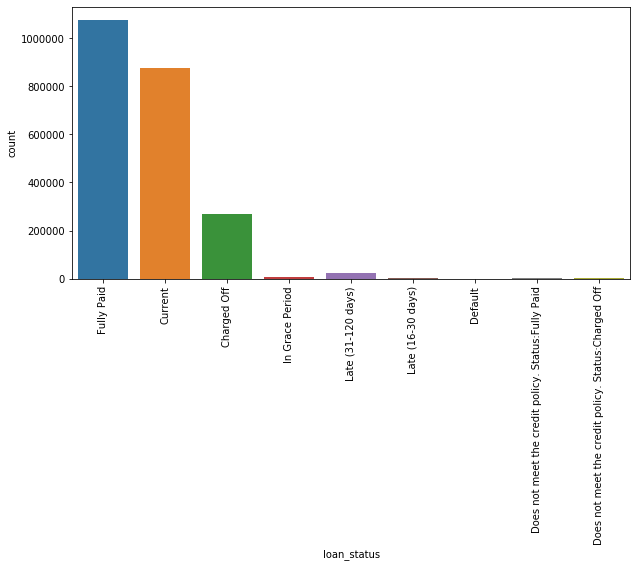

In [5]:
# look at the ratio of Nan and other irrelevant values

plt.figure(figsize=(10,5))
ax = sns.countplot(x='loan_status', data=df)
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()

## Step 2: Transform the data
I want to know if the person paid back or not. Therefore, it is nessesary to select rows having 'Fully Paid' or 'Charged Off'


In [6]:
# Select all rows with 'Fully Paid' or 'Charged Off'

df_clean = df[(df['loan_status']=="Fully Paid") | (df['loan_status']=="Charged Off")]

print('The previous length of data:', len(df))
print('The new length of data:', len(df_clean))
removed = (len(df)-len(df_clean))*100/len(df)
print('The percent of removed data:', round(removed,1)) 
      

The previous length of data: 2260701
The new length of data: 1345310
The percent of removed data: 40.5


The 40% of data was removed, and this is risky for a small dataset. However, this dataset is large enough to remove 40%. There are still 1345310 data points. 

In [7]:
# Lets deal with the curse of dimensionality.
# Find the percent of missing values in columns.

pd.set_option("display.max_rows", 10)

df_missing = 100* df_clean.isnull().sum()/len(df_clean)
df_missing.sort_values(ascending=False)

member_id                                     100.000000
next_pymnt_d                                  100.000000
orig_projected_additional_accrued_interest     99.720585
hardship_start_date                            99.572292
hardship_end_date                              99.572292
                                                 ...    
pub_rec                                         0.000000
open_acc                                        0.000000
hardship_flag                                   0.000000
fico_range_high                                 0.000000
id                                              0.000000
Length: 151, dtype: float64

In [8]:
# Remove all columns with more than 6% of missing values

for title in df_missing[df_missing>6].index:   
    df_clean = df_clean.drop(title,axis=1)
    
print('number of columns:', len(df_clean.columns))

number of columns: 89


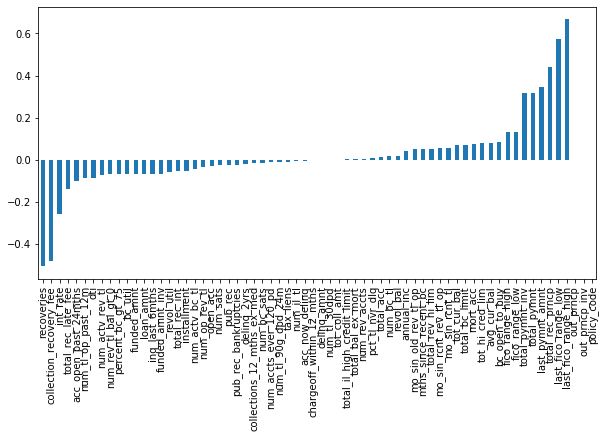

In [9]:
# Add a column showing loan status with numeric values
# Fully Paid is 1
# Charged Off is 0

df_clean['loan_mapped'] = df_clean['loan_status'].map({'Fully Paid':1,'Charged Off':0})

# Find the correlation between the loan status (loan_mapped) and other columns

df_corr = df_clean.corr()['loan_mapped'].sort_values().drop('loan_mapped')

plt.figure(figsize=(10,5))
df_corr.plot(kind='bar')
plt.show()

In [10]:
# Remove columns with constant values. 
# These columns end up null values on the correlation figure.

for title in df_corr[df_corr.isnull()].index:
    df_clean = df_clean.drop(title,axis=1)

    
# Remove all columns within a range of -0.2 and 0.2

for title in df_corr[(df_corr>-0.2)&(df_corr<0.2)].index:
    df_clean = df_clean.drop(title,axis=1)
    
print('number of columns:', len(df_clean.columns))


number of columns: 33


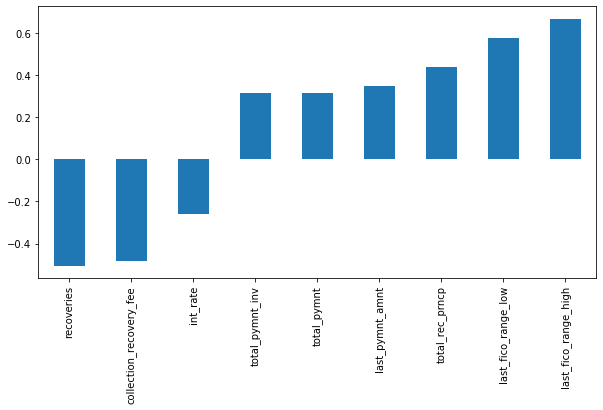

In [11]:
# Lets see the cleaned correlation figure.

df_corr = df_clean.corr()['loan_mapped'].sort_values().drop('loan_mapped')

plt.figure(figsize=(10,5))
df_corr.plot(kind='bar')
plt.show()


In [12]:
# Show all columns except the columns on the correlation figure

for title in df_clean.columns:
    if title not in df_corr.index:
        print(title)

id
term
grade
sub_grade
emp_length
home_ownership
verification_status
issue_d
loan_status
pymnt_plan
url
purpose
title
zip_code
addr_state
earliest_cr_line
initial_list_status
last_pymnt_d
last_credit_pull_d
application_type
hardship_flag
disbursement_method
debt_settlement_flag
loan_mapped


In [13]:
# Remove clearly uninformative columns

remove_columns = ['id', 'issue_d', 'pymnt_plan', 'url', 'last_pymnt_d', 'last_credit_pull_d']

for title in remove_columns:
    df_clean = df_clean.drop(title,axis=1)

print('number of columns:', len(df_clean.columns))



number of columns: 27


In [14]:
# look at unique values (categorical variables). 
# If the number is too large, cannot convert the column with dummy variables

for title in df_clean.columns:
    if title not in df_corr.index:
        nunique = df_clean[title].nunique()
        print(title, nunique, 'unique values')

term 2 unique values
grade 7 unique values
sub_grade 35 unique values
emp_length 11 unique values
home_ownership 6 unique values
verification_status 3 unique values
loan_status 2 unique values
purpose 14 unique values
title 61682 unique values
zip_code 943 unique values
addr_state 51 unique values
earliest_cr_line 739 unique values
initial_list_status 2 unique values
application_type 2 unique values
hardship_flag 1 unique values
disbursement_method 2 unique values
debt_settlement_flag 2 unique values
loan_mapped 2 unique values


In [15]:
# Remove columns with too many categorical variables

remove_columns = ['title', 'zip_code', 'addr_state', 'earliest_cr_line']
for title in remove_columns:
    df_clean = df_clean.drop(title,axis=1)
    
    
# Remove coulumn with just 1 categorical variable

df_clean = df_clean.drop('hardship_flag',axis=1)

print('number of columns:', len(df_clean.columns))

number of columns: 22


In [16]:
# Look at term column

df_clean['term'].value_counts()

 36 months    1020743
 60 months     324567
Name: term, dtype: int64

In [17]:
# Convert the string to integer

df_clean['term'] = df_clean['term'].apply(lambda term: int(term[:3]))


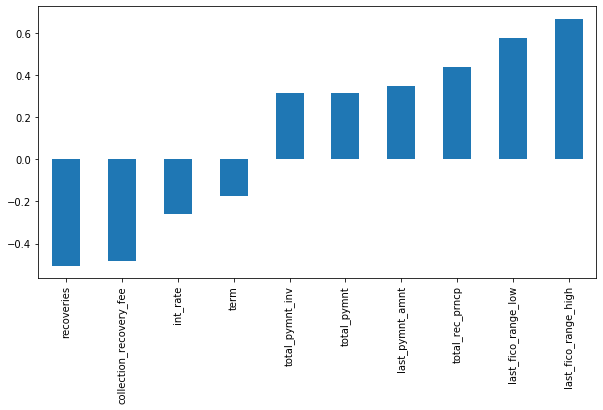

In [18]:
# Find the correlation between the loan status (loan_mapped) and other columns

df_corr = df_clean.corr()['loan_mapped'].sort_values().drop('loan_mapped')
plt.figure(figsize=(10,5))
df_corr.plot(kind='bar')
plt.show()

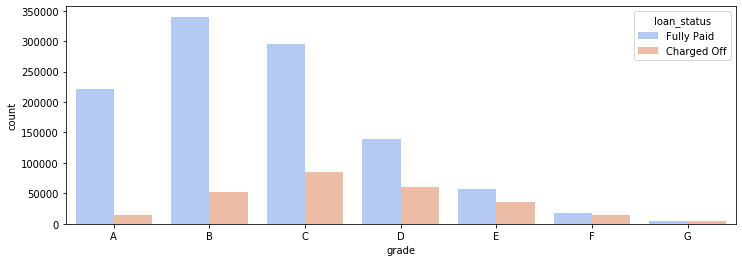

In [19]:
# Look at grade column

plt.figure(figsize=(12,4))
sorted_grade = sorted(df_clean['grade'].unique())
sns.countplot(x='grade',data=df_clean,order = sorted_grade,palette='coolwarm' ,hue='loan_status')


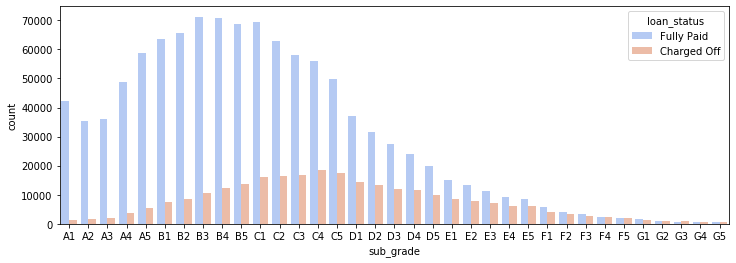

In [20]:
# Look at sub_grade column

plt.figure(figsize=(12,4))
sorted_subgrade = sorted(df_clean['sub_grade'].unique())
sns.countplot(x='sub_grade',data=df_clean,order=sorted_subgrade,palette='coolwarm' ,hue='loan_status')


In [21]:
# Convert string variable to dummy variable

dummy = pd.get_dummies(df_clean['sub_grade'],drop_first=True)
df_clean = df_clean.drop('sub_grade',axis=1)
df_clean = pd.concat([df_clean,dummy],axis=1)

In [22]:
# Remove grade column because it is similar to the subgrade column

df_clean = df_clean.drop('grade',axis=1)


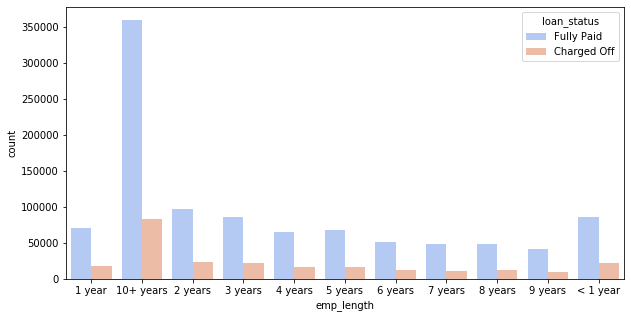

In [23]:
# Look at emp_length

sorted_title = df_clean['emp_length'].dropna().sort_values().unique()
plt.figure(figsize=(10,5))
sns.countplot(x='emp_length', data=df_clean, order=sorted_title, hue='loan_status',palette='coolwarm') 


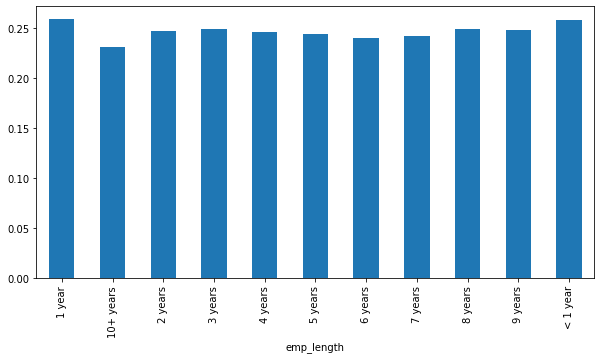

In [24]:
# Look at the ratio 

c_length = df[df['loan_status']=="Charged Off"].groupby("emp_length").count()['loan_status']
f_length = df[df['loan_status']=="Fully Paid"].groupby("emp_length").count()['loan_status']
ratio = c_length/f_length

plt.figure(figsize=(10,5))
ratio.plot(kind='bar')


In [25]:
# Remove the emp_length column 
# The column is irrelevant to loan status according to the ratio

df_clean = df_clean.drop('emp_length', axis=1)

In [26]:
# Look at the percent of home_ownership column

df_clean['home_ownership'].value_counts()*100/len(df_clean)


MORTGAGE    49.474025
RENT        39.724747
OWN         10.765697
ANY          0.021259
OTHER        0.010704
NONE         0.003568
Name: home_ownership, dtype: float64

In [27]:
# gather similar information

df_clean['home_ownership'] = df_clean['home_ownership'].replace(['ANY','NONE'],'OTHER')

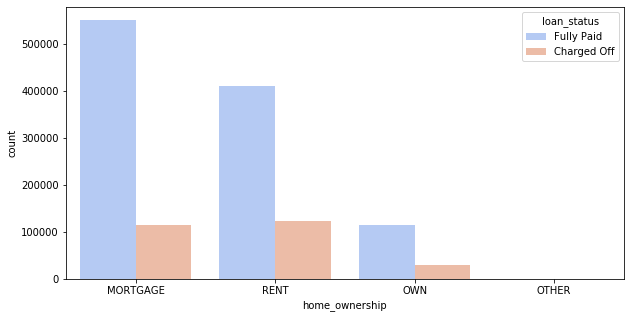

In [28]:
plt.figure(figsize=(10,5))
sns.countplot(x='home_ownership', data=df_clean, hue='loan_status', palette='coolwarm')


In [29]:
# Convert string variable to dummy variable

dummy = pd.get_dummies(df_clean['home_ownership'],drop_first=True)
df_clean = df_clean.drop('home_ownership',axis=1)
df_clean = pd.concat([df_clean,dummy],axis=1)

In [30]:
# Look at verification column

df_clean['verification_status'].value_counts()

Source Verified    521273
Verified           418336
Not Verified       405701
Name: verification_status, dtype: int64

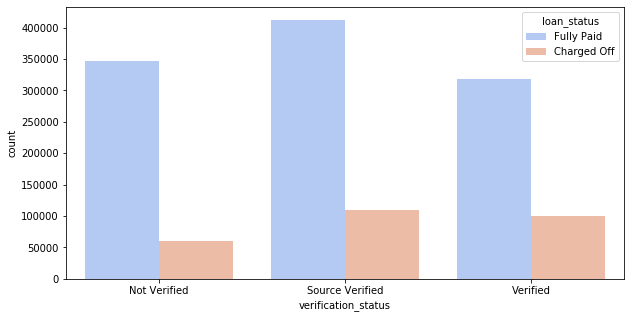

In [31]:
plt.figure(figsize=(10,5))
sns.countplot(x='verification_status', data=df_clean, hue='loan_status', palette='coolwarm')


In [32]:
# Convert string variable to dummy variable

dummy = pd.get_dummies(df_clean['verification_status'],drop_first=True)
df_clean = df_clean.drop('verification_status',axis=1)
df_clean = pd.concat([df_clean,dummy],axis=1)


In [33]:
# Look at purpose columns

df_clean['purpose'].value_counts()

debt_consolidation    780321
credit_card           295279
home_improvement       87504
other                  77875
major_purchase         29425
                       ...  
vacation                9065
house                   7253
wedding                 2294
renewable_energy         933
educational              326
Name: purpose, Length: 14, dtype: int64

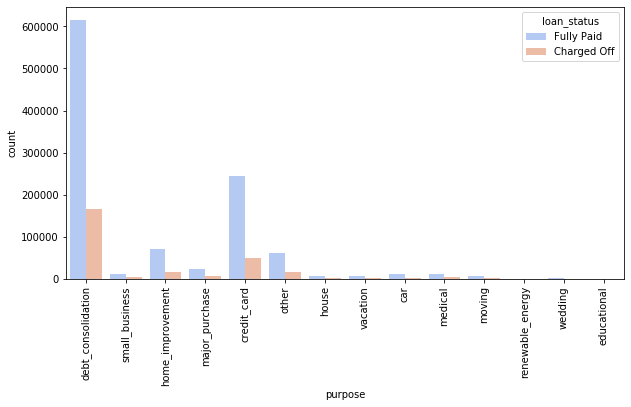

In [34]:
plt.figure(figsize=(10,5))
ax = sns.countplot(x='purpose', data=df_clean, hue='loan_status', palette='coolwarm')
ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
plt.show()



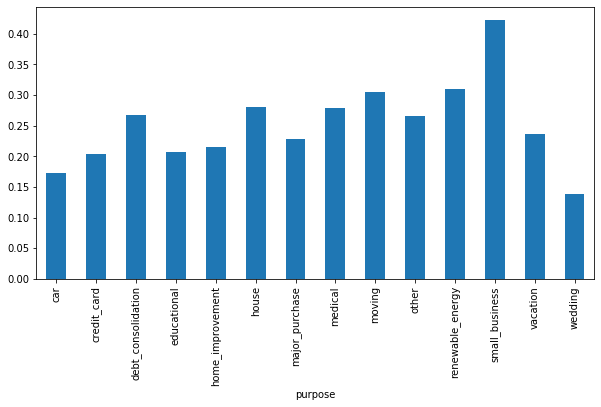

In [35]:
# Look at the ratio 

c_purpose = df[df['loan_status']=="Charged Off"].groupby("purpose").count()['loan_status']
f_purpose = df[df['loan_status']=="Fully Paid"].groupby("purpose").count()['loan_status']
ratio = c_purpose/f_purpose

plt.figure(figsize=(10,5))
ratio.plot(kind='bar')


In [36]:
# Convert string variable to dummy variable

dummy = pd.get_dummies(df_clean['purpose'],drop_first=True)
df_clean = df_clean.drop('purpose',axis=1)
df_clean = pd.concat([df_clean,dummy],axis=1)


In [37]:
# Look at initial_list_status column

df['initial_list_status'].value_counts()

w    1535467
f     725201
Name: initial_list_status, dtype: int64

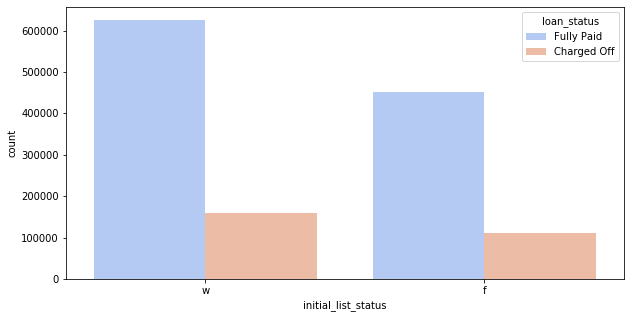

In [38]:
plt.figure(figsize=(10,5))
sns.countplot(x='initial_list_status', data=df_clean, hue='loan_status', palette='coolwarm')
plt.show()



In [39]:
# Convert string variable to dummy variable

dummy = pd.get_dummies(df_clean['initial_list_status'],drop_first=True)
df_clean = df_clean.drop('initial_list_status',axis=1)
df_clean = pd.concat([df_clean,dummy],axis=1)


In [40]:
# Look at application_type column

df_clean['application_type'].value_counts()

Individual    1319510
Joint App       25800
Name: application_type, dtype: int64

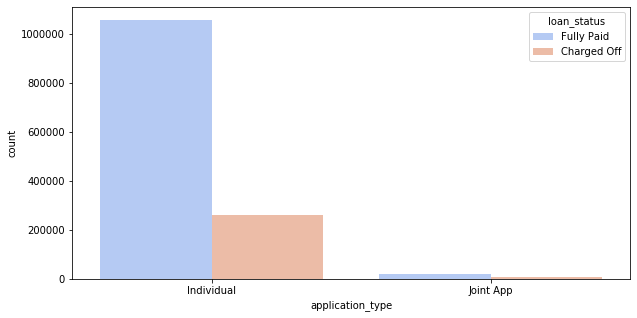

In [41]:
plt.figure(figsize=(10,5))
sns.countplot(x='application_type', data=df_clean, hue='loan_status', palette='coolwarm')
plt.show()



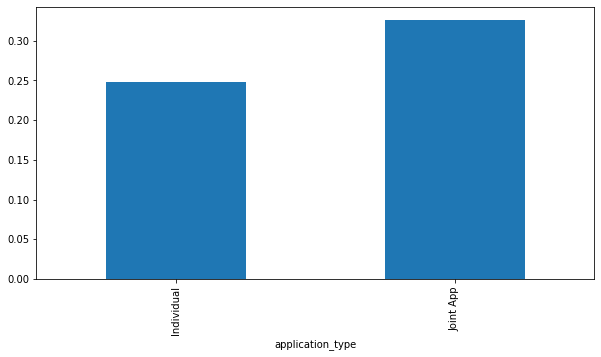

In [42]:
# Look at the ratio 

c_purpose = df[df['loan_status']=="Charged Off"].groupby("application_type").count()['loan_status']
f_purpose = df[df['loan_status']=="Fully Paid"].groupby("application_type").count()['loan_status']
ratio = c_purpose/f_purpose

plt.figure(figsize=(10,5))
ratio.plot(kind='bar')


In [43]:
# Convert string variable to dummy variable

dummy = pd.get_dummies(df_clean['application_type'],drop_first=True)
df_clean = df_clean.drop('application_type',axis=1)
df_clean = pd.concat([df_clean,dummy],axis=1)


In [44]:
# Look at disbursement_method column

df_clean['disbursement_method'].value_counts()

Cash         1338410
DirectPay       6900
Name: disbursement_method, dtype: int64

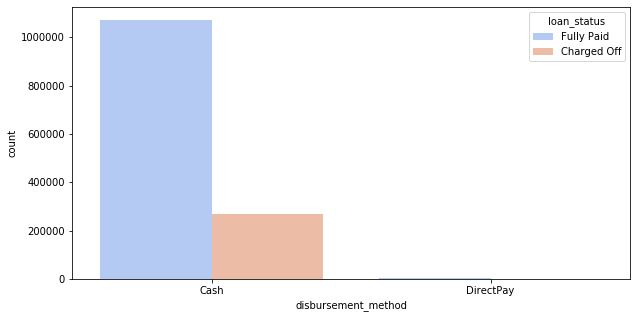

In [45]:
plt.figure(figsize=(10,5))
sns.countplot(x='disbursement_method', data=df_clean, hue='loan_status', palette='coolwarm')
plt.show()



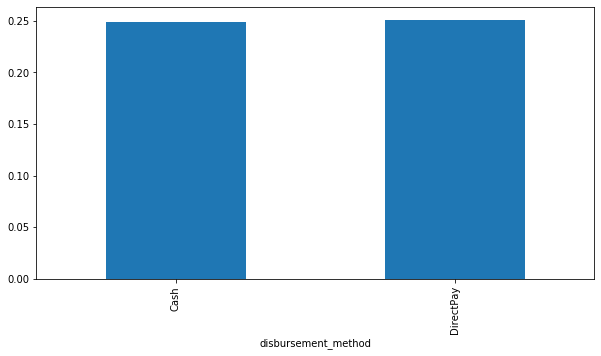

In [46]:
# Look at the ratio 

c_purpose = df[df['loan_status']=="Charged Off"].groupby("disbursement_method").count()['loan_status']
f_purpose = df[df['loan_status']=="Fully Paid"].groupby("disbursement_method").count()['loan_status']
ratio = c_purpose/f_purpose

plt.figure(figsize=(10,5))
ratio.plot(kind='bar')


In [47]:
# Remove the disbursement_method column because the radio is similar

df_clean = df_clean.drop('disbursement_method', axis=1)

In [48]:
# Look at debt_settlement_flag column

df_clean['debt_settlement_flag'].value_counts()

N    1312034
Y      33276
Name: debt_settlement_flag, dtype: int64

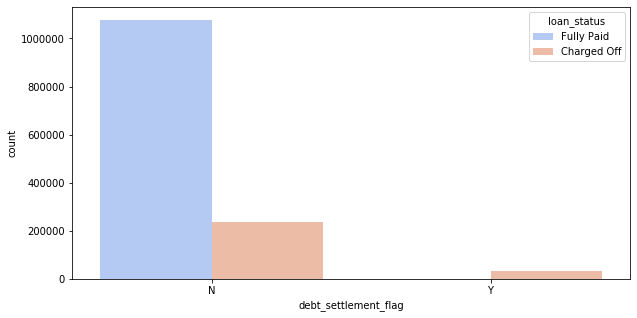

In [49]:
plt.figure(figsize=(10,5))
sns.countplot(x='debt_settlement_flag', data=df_clean, hue='loan_status', palette='coolwarm')
plt.show()



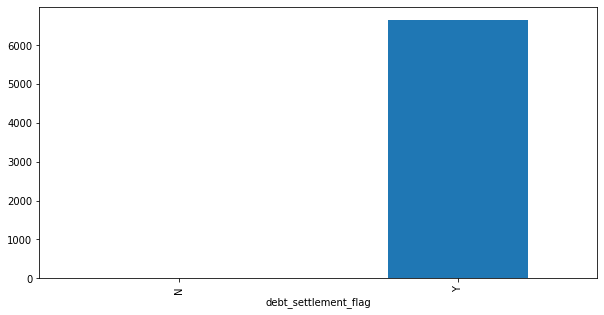

In [50]:
# Look at the ratio 

c_purpose = df[df['loan_status']=="Charged Off"].groupby("debt_settlement_flag").count()['loan_status']
f_purpose = df[df['loan_status']=="Fully Paid"].groupby("debt_settlement_flag").count()['loan_status']
ratio = c_purpose/f_purpose

plt.figure(figsize=(10,5))
ratio.plot(kind='bar')


In [51]:
# Remove debt_settlement_flag because the ratio is extreme

df_clean = df_clean.drop('debt_settlement_flag', axis=1)

In [52]:
# Make sure no more string columns

df_clean.select_dtypes(['object']).columns

Index(['loan_status'], dtype='object')

In [53]:
# Remove loan_status because it is replaced with loan_mapped 

df_clean = df_clean.drop('loan_status', axis=1)

In [54]:
# Make sure no more missing values again

df_clean.isnull().sum().sort_values(ascending=False)

Joint App    0
E2           0
D5           0
D4           0
D3           0
            ..
F3           0
F2           0
F1           0
E5           0
term         0
Length: 65, dtype: int64

In [55]:
# Save the dataframe in a csv file

df_clean.to_csv(path+'clean_data.csv')